<a href="https://colab.research.google.com/github/andreidore/aicrowd_blitz_may_2020/blob/master/minileaves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
!pip install wandb==0.8.33


In [16]:
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/test-images.npy
!wget https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/all_classes.txt

--2020-05-10 08:01:26--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-images.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.12, 130.117.252.10, 130.117.252.16, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.117.252.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133527680 (127M) [binary/octet-stream]
Saving to: ‘train-images.npy.1’

train-images.npy.1  100%[===================>] 127.34M  64.9MB/s    in 2.0s    

2020-05-10 08:01:28 (64.9 MB/s) - ‘train-images.npy.1’ saved [133527680/133527680]

--2020-05-10 08:01:30--  https://s3.eu-central-1.wasabisys.com/aicrowd-practice-challenges/public/minileaves/v0.1/train-labels.npy
Resolving s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)... 130.117.252.16, 130.117.252.12, 130.117.252.11, ...
Connecting to s3.eu-central-1.wasabisys.com (s3.eu-central-1.wasabisys.com)|130.11

In [0]:
from collections import Counter
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers, optimizers
import matplotlib.pyplot as plt
%matplotlib inline
import wandb
from wandb.keras import WandbCallback

In [18]:
wandb.init(name='CNN-5', project="minileaves",config={"hyper": "parameter"})

wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/andrei-dore/minileaves/runs/wk213iw7

## Import data

In [0]:
train_images_path = "train-images.npy" #path where data is stored
train_labels_path = "train-labels.npy"

train_images = np.load(train_images_path)
train_labels = np.load(train_labels_path)

# Load Class mapping
class_names = [x.strip() for x in open("all_classes.txt").readlines()]

In [20]:
print(train_images.shape)
print(train_labels.shape)
print(train_labels[0:10])
print(class_names)


(43466, 32, 32, 3)
(43466,)
[ 7  4  9 29 20 15 37  5 29 28]
['apple-apple-scab', 'apple-black-rot', 'apple-cedar-apple-rust', 'apple-healthy', 'blueberry-healthy', 'cherry-including-sour-healthy', 'cherry-including-sour-powdery-mildew', 'corn-maize-cercospora-leaf-spot-gray-leaf-spot', 'corn-maize-common-rust', 'corn-maize-healthy', 'corn-maize-northern-leaf-blight', 'grape-black-rot', 'grape-esca-black-measles', 'grape-healthy', 'grape-leaf-blight-isariopsis-leaf-spot', 'orange-haunglongbing-citrus-greening', 'peach-bacterial-spot', 'peach-healthy', 'pepper-bell-bacterial-spot', 'pepper-bell-healthy', 'potato-early-blight', 'potato-healthy', 'potato-late-blight', 'raspberry-healthy', 'soybean-healthy', 'squash-powdery-mildew', 'strawberry-healthy', 'strawberry-leaf-scorch', 'tomato-bacterial-spot', 'tomato-early-blight', 'tomato-healthy', 'tomato-late-blight', 'tomato-leaf-mold', 'tomato-septoria-leaf-spot', 'tomato-spider-mites-two-spotted-spider-mite', 'tomato-target-spot', 'tomato-

## Visualize date

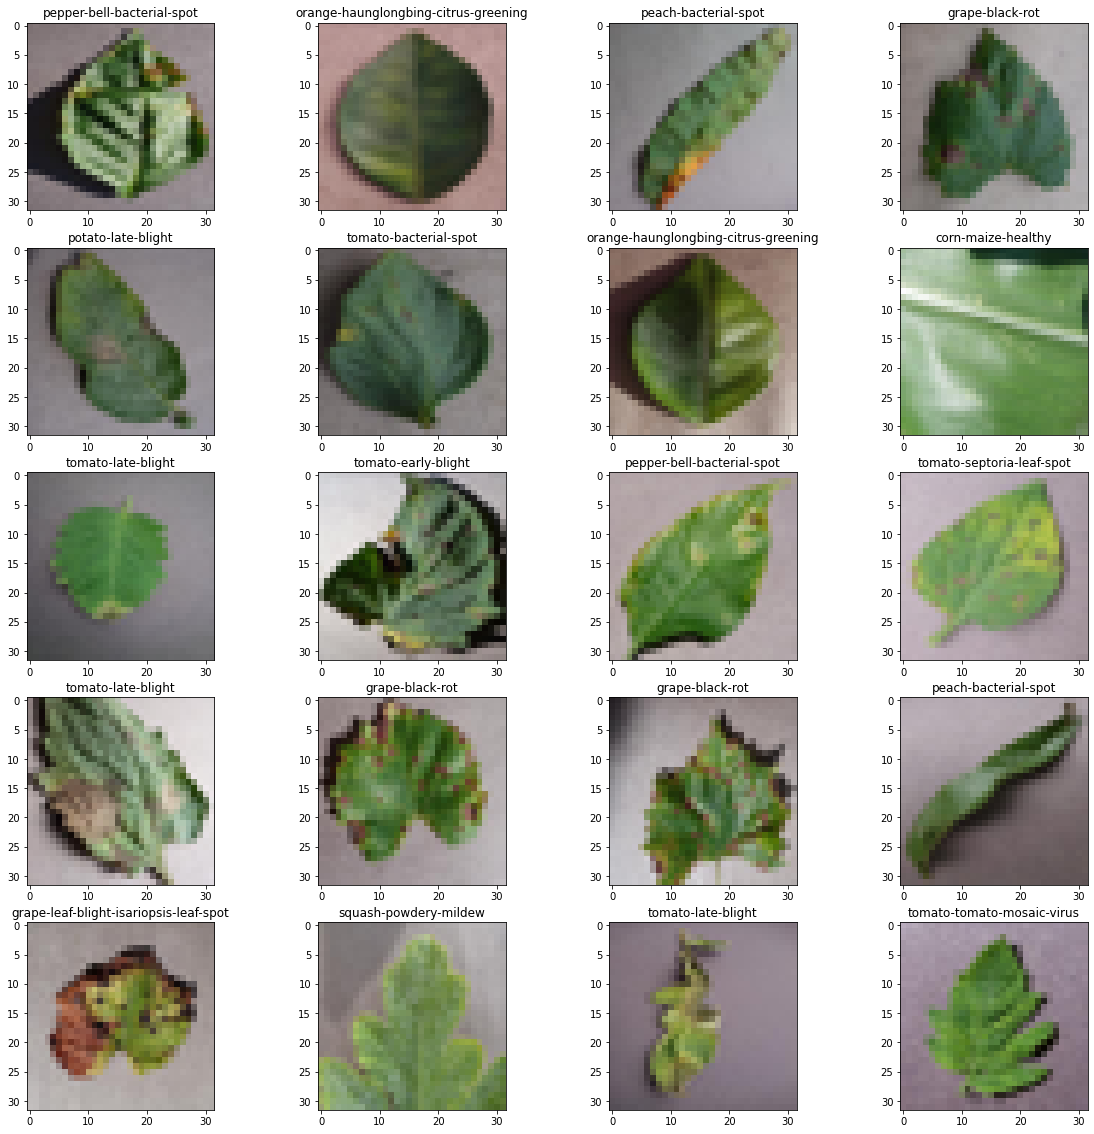

In [21]:
def random_data_sample():
    """
    Returns a random data sample from the training set
    """
    random_index = np.random.randint(0, train_images.shape[0])
    # Render the image
    image_array = train_images[random_index]
    class_label = train_labels[random_index] # an integral number in [0-38)
    class_name = class_names[class_label] # a human readable class name
    return image_array, class_label, class_name



fig=plt.figure(figsize=(20, 20))
w=10
h=10
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    image,class_label,class_name=random_data_sample()
    plt.imshow(image)
    plt.title(class_name)

## Distribution

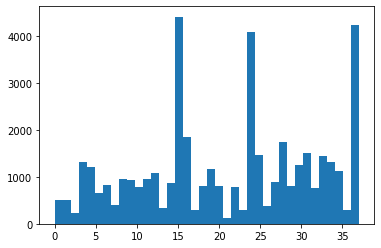

In [22]:
#data_counter = Counter(train_labels)
#unique_class_indices = data_counter.keys()

#for _class_index in unique_class_indices:
#    print("Class Index : ", _class_index)
#    print("Class Name : ", class_names[_class_index])
#    print("Number of images in the dataset : ", data_counter[_class_index])
#    print("="*100)



plt.hist(train_labels, bins = len(np.unique(train_labels)))
plt.show()


In [0]:
X_train, X_val= train_test_split(train_images, test_size=0.2, random_state=42)
y_train, y_val= train_test_split(train_labels, test_size=0.2, random_state=42)

In [24]:
#X_train = X_train.astype('float32')/255
#X_val = X_val.astype('float32')/255
print(np.unique(y_train))
class_weights = compute_class_weight('balanced',np.unique(y_train),y_train)
class_weights = dict(enumerate(class_weights))
print(class_weights)

mean = np.mean(X_train)
std = np.std(X_train)
X_train = (X_train-mean)/(std+1e-7)
X_val = (X_val-mean)/(std+1e-7)


# one-hot encode the labels
num_classes = len(np.unique(y_train))
y_train = to_categorical(y_train, num_classes)
y_val = to_categorical(y_val, num_classes)


# print shape of training set
print('x_train shape:', X_train.shape)

# print number of training, validation, and test images
print(X_train.shape[0], 'train samples')
print(X_val.shape[0], 'validation samples')


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
{0: 2.2318356867779205, 1: 2.3402880603042133, 2: 5.38266253869969, 3: 0.87564845127172, 4: 0.967286079893179, 5: 1.7429573934837093, 6: 1.3739529002686897, 7: 2.8506312510247582, 8: 1.1656721421387866, 9: 1.234888841537041, 10: 1.4034549564094285, 11: 1.1776739145160198, 12: 1.0727463441722713, 13: 3.3154080854309687, 14: 1.3556335282651073, 15: 0.25347718326286633, 16: 0.6174444207685205, 17: 3.8447589562140645, 18: 1.4253156255123791, 19: 0.9903167008430166, 20: 1.4342517736347138, 21: 9.946224256292906, 22: 1.471145709933999, 23: 3.927264513214366, 24: 0.2805188938010262, 25: 0.7689517912428129, 26: 3.0299756012547925, 27: 1.3034937771779878, 28: 0.6564222608170354, 29: 1.401305714515999, 30: 0.920576088107593, 31: 0.7427375256322625, 32: 1.5250877192982457, 33: 0.8206750059004012, 34: 0.8480561923808595, 35: 1.031626416661722, 36: 3.6749101669837243, 37: 0.269212307

In [25]:
# number of hidden units variable 
# we are declaring this variable here and use it in our CONV layers to make it easier to update from one place
base_hidden_units = 32

# l2 regularization hyperparameter
weight_decay = 1e-4 

# instantiate an empty sequential model 
model = Sequential()

# CONV1
# notice that we defined the input_shape here because this is the first CONV layer. 
# we don’t need to do that for the remaining layers
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=X_train.shape[1:]))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV2
model.add(Conv2D(base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# CONV3
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV4
model.add(Conv2D(2*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# CONV5
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# CONV6
model.add(Conv2D(4*base_hidden_units, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

# FC7
#model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_6 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)       

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=False
    )

# compute the data augmentation on the training set
datagen.fit(X_train)

In [0]:
optimizer = Adam(lr=0.001,decay=1e-6)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, 
              metrics=['accuracy'])

In [28]:
# compile the model


lrr= ReduceLROnPlateau(
                      monitor='val_loss', #Metric to be measured
                       factor=.5, #Factor by which learning rate will be reduced
                       patience=5,  #No. of epochs after which if there is no improvement in the val_acc, the learning rate is reduced
                       min_lr=1e-6) #The minimum learning rate 

model_checkpoint=ModelCheckpoint(filepath="best_model.hdf5",verbose=1,save_best_only=True)
wand_callback=WandbCallback()

batch_size=128

history=model.fit(datagen.flow(X_train, y_train, batch_size=batch_size),steps_per_epoch=X_train.shape[0] // batch_size,epochs=100,verbose=2,
          callbacks=[model_checkpoint,wand_callback,lrr],validation_data=(X_val,y_val),shuffle=True)

Epoch 1/100


wandb: Wandb version 0.8.35 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade



Epoch 00001: val_loss improved from inf to 3.56400, saving model to best_model.hdf5
271/271 - 27s - loss: 1.7384 - accuracy: 0.5475 - val_loss: 3.5640 - val_accuracy: 0.3252 - lr: 0.0010
Epoch 2/100

Epoch 00002: val_loss improved from 3.56400 to 0.60628, saving model to best_model.hdf5
271/271 - 27s - loss: 0.8571 - accuracy: 0.7469 - val_loss: 0.6063 - val_accuracy: 0.8278 - lr: 0.0010
Epoch 3/100

Epoch 00003: val_loss did not improve from 0.60628
271/271 - 26s - loss: 0.6270 - accuracy: 0.8132 - val_loss: 0.7381 - val_accuracy: 0.7948 - lr: 0.0010
Epoch 4/100

Epoch 00004: val_loss did not improve from 0.60628
271/271 - 26s - loss: 0.5129 - accuracy: 0.8488 - val_loss: 1.1786 - val_accuracy: 0.7143 - lr: 0.0010
Epoch 5/100

Epoch 00005: val_loss improved from 0.60628 to 0.54324, saving model to best_model.hdf5
271/271 - 27s - loss: 0.4373 - accuracy: 0.8720 - val_loss: 0.5432 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 6/100

Epoch 00006: val_loss did not improve from 0.54324
271/27

In [0]:
model.load_weights('best_model.hdf5')

In [30]:
scores = model.evaluate(X_val, y_val, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

68/68 [==============================] - 1s 14ms/step - loss: 0.1010 - accuracy: 0.9827

Test result: 98.275 loss: 0.101


In [0]:
test_file_path = "test-images.npy"
test_images = np.load(test_file_path)

In [0]:
#test_images=test_images.astype('float32')/255
test_images = (test_images-mean)/(std+1e-7)

In [0]:
submission=model.predict(test_images)

In [34]:

submission=np.argmax(submission,axis=1)
print(submission.shape)

(10838,)


## Save the prediction to csv

In [0]:
import pandas as pd
submission = pd.DataFrame(submission)
submission.to_csv('submission.csv',header=['class_index'],index=False)

## To download the generated csv in colab run the below command

In [0]:
from google.colab import files
files.download('submission.csv')